# Mixed Precision Training
author: Mengliu Zhao\
date: Sept 14, 2024

In this notebook, I'll demo the following using the FashionMNIST dataset and ResNet50:
1. training with FP32 and the gradient value distribution; 
2. training directly with FP16 and the loss will become NAN in the end;
3. training with amp library without loss scaling;
4. training with amp library with loss scaling.
For all the experiments, the hyperparameters are kept the same.

Result:
1. we can see that the FP32 training takes in total 333 seconds while the FP16 training takes only 141 seconds, the time boost is 2.36X
2. since the input format is also FT16, it saves half the memory on GPU
3. the evaluation of the FP16 model matches the FT32 model on precision, recall and F1-score

## 1. Training with FP32
For all the following experiments, We train the ResNet50 model on the FashionMNIST dataset, all using the same hyperparameters.

Note that we record a high_prec_ratio variable, which is the ratio of gradients with absolute value less than 2**(-24), to the total number of gradients. We can see that the ratio is around 23%, which is significant and can explain why directly training with FP16 would cause the failure.

The training time is 333 seconds, and the evaluation Precision/Recall/F1-score are 98%/98%/98% respectively. 

In [3]:
import tqdm
import numpy as np
from sklearn.metrics import classification_report

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

from FashionMNIST import FashionMNIST
import torchvision.transforms as transforms

train_dataset = FashionMNIST("./FashionMNIST",
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True,
                             )
test_dataset = FashionMNIST("./FashionMNIST",
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True,
                            )

train_dataloader = DataLoader(train_dataset,
                              batch_size=1024,
                              shuffle=True,
                              drop_last=True,
                              )

test_dataloader = DataLoader(train_dataset,
                              batch_size=1024,
                              shuffle=False,
                              drop_last=False,
                              )


In [4]:
import time
import numpy as np

model = torchvision.models.resnet50()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(2048, 10)

optimizer = optim.Adam(model.parameters(),
                      lr=1e-4,
                      betas=[0.9, 0.99],
                      weight_decay=1e-5,
                      )

loss_fun = nn.CrossEntropyLoss()
fp32_training_loss = []
fp32_highprec_ratio = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

start_time = time.time()
for epoch in range(10):
    model.train()

    for batch_idx, (image, target) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):

        optimizer.zero_grad()

        prediction = model(image.to(device))

        loss = loss_fun(prediction, target.to(device))
        loss.backward()

        optimizer.step()

        high_precision_param = np.sum([torch.sum(torch.abs(optimizer.param_groups[0]["params"][idx].grad) < 2**(-24)).detach().cpu().numpy() for idx in range(len(optimizer.param_groups[0]["params"]))])
        total_param = np.sum([np.sum(np.prod(list(optimizer.param_groups[0]["params"][idx].grad.size()))) for idx in range(len(optimizer.param_groups[0]["params"]))])
        high_prec_ratio = high_precision_param / total_param

        fp32_training_loss.append(loss.detach().cpu().numpy())
        fp32_highprec_ratio.append(high_prec_ratio)

end_time = time.time()
print("total training time:", end_time - start_time, "seconds")
torch.save(model.state_dict(), "resnet50_epoch10_fp32.pth")


100%|██████████| 58/58 [00:32<00:00,  1.78it/s]


total training time: 333.8106942176819 seconds


Text(0.5, 1.0, 'ratio of param < 2**(-24) per step')

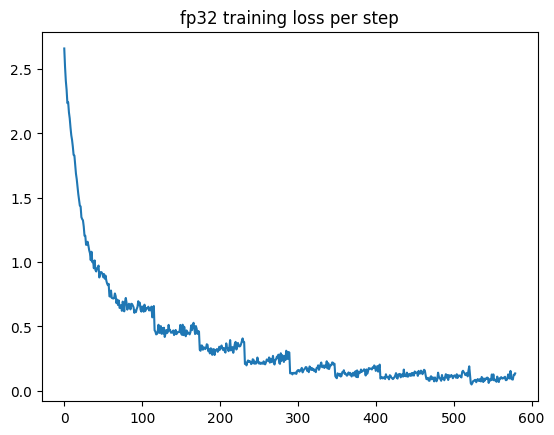

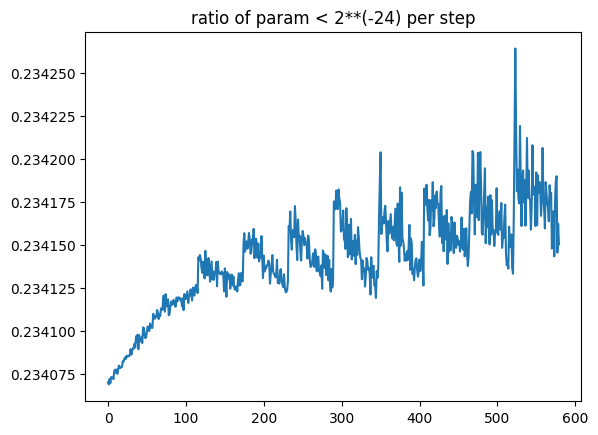

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fp32_training_loss)
plt.title("fp32 training loss per step")

plt.figure()
plt.plot(fp32_highprec_ratio)
plt.title("ratio of param < 2**(-24) per step")

In [6]:
model = model.to(device)
model.eval()

total_target = []
total_pred = []
for batch_idx, (image, target) in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):

    with torch.no_grad():
        output = model(image.to(device))
        prediction = torch.argmax(output, dim=-1)

    total_target.extend(target)
    total_pred.extend(prediction.detach().cpu().numpy())

print(classification_report(total_target, total_pred))

100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6000
           1       1.00      0.99      0.99      6000
           2       0.95      0.98      0.97      6000
           3       0.97      0.99      0.98      6000
           4       0.97      0.95      0.96      6000
           5       0.99      0.99      0.99      6000
           6       0.96      0.95      0.95      6000
           7       0.99      0.99      0.99      6000
           8       0.99      0.99      0.99      6000
           9       0.99      0.99      0.99      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



## 2. Training with FP16 directly

This section we use FP16 for training directly, by calling model.half().

We can see in the end, the loss is NAN, which means the training totally failed.

In [17]:
import time

model = torchvision.models.resnet50()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(2048, 10)

optimizer = optim.Adam(model.parameters(),
                      lr=1e-4,
                      betas=[0.9, 0.99],
                      weight_decay=1e-5,
                      )

# Training loop
loss_fun = nn.CrossEntropyLoss()
fp16_training_loss = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model = model.half()

start_time = time.time()
for epoch in range(10):
    model.train()

    for batch_idx, (image, target) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):

        optimizer.zero_grad()

        prediction = model(image.to(device).half())

        loss = loss_fun(prediction.float(), target.to(device))
        loss.backward()

        optimizer.step()

        fp16_training_loss.append(loss.detach().cpu().numpy())

end_time = time.time()
print("total training time:", end_time - start_time, "seconds")
print(fp16_training_loss[-1])
torch.save(model.state_dict(), "resnet50_epoch10_fp16.pth")

100%|██████████| 58/58 [00:14<00:00,  4.00it/s]

total training time: 145.9611418247223 seconds
nan


## 3. Training with AMP w/o loss scaling
Now that we use torch.amp library, which only includes one lines of extra script since we don't use loss scaling:\
`with torch.autocast(device_type="cuda")`

The training time is reduced to 141 seconds, which is 2.36X boost over FP32 and the precision/recall/F1-score are all kept unchanged.

In [18]:
import time

model = torchvision.models.resnet50()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(2048, 10)

optimizer = optim.Adam(model.parameters(),
                      lr=1e-4,
                      betas=[0.9, 0.99],
                      weight_decay=1e-5,
                      )

# Training loop
loss_fun = nn.CrossEntropyLoss()
amp_woscaling_training_loss = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

start_time = time.time()
for epoch in range(10):
    model.train()

    for batch_idx, (image, target) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):

        optimizer.zero_grad()

        with torch.autocast(device_type="cuda"):
          prediction = model(image.to(device).half())

          loss = loss_fun(prediction, target.to(device))
          loss.backward()

        optimizer.step()

        amp_woscaling_training_loss.append(loss.detach().cpu().numpy())

end_time = time.time()
print("total training time:", end_time - start_time, "seconds")
print(amp_woscaling_training_loss[-1])
torch.save(model.state_dict(), "resnet50_epoch10_amp_wo_scaling.pth")

100%|██████████| 58/58 [00:13<00:00,  4.15it/s]


total training time: 141.18955826759338 seconds
0.11887659


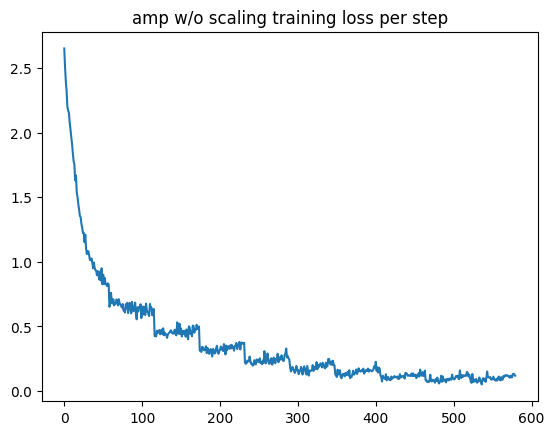

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(amp_woscaling_training_loss)
_ = plt.title("amp w/o scaling training loss per step")

In [20]:
model = model.to(device)
model.eval()

total_target = []
total_pred = []
for batch_idx, (image, target) in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):

    with torch.no_grad():
      with torch.autocast(device_type="cuda"):
        output = model(image.to(device).half())
        prediction = torch.argmax(output, dim=-1)

    total_target.extend(target)
    total_pred.extend(prediction.detach().cpu().numpy())

print(classification_report(total_target, total_pred))

100%|██████████| 59/59 [00:11<00:00,  4.93it/s]


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6000
           1       0.99      1.00      1.00      6000
           2       0.95      0.97      0.96      6000
           3       0.99      0.97      0.98      6000
           4       0.96      0.95      0.96      6000
           5       0.99      0.99      0.99      6000
           6       0.95      0.93      0.94      6000
           7       0.98      0.99      0.99      6000
           8       0.99      0.99      0.99      6000
           9       1.00      0.98      0.99      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



## 4. Training with AMP with loss scaling
Loss scaling is not necessary as the mixed precision training above works. But here we demo how to add the loss scaling by introducint the `GradScaler`. We just need three extra lines of code in total and wrap the optimizer and the loss with the scaler during training:\
* `scaler = torch.cuda.amp.GradScaler()`
* `with torch.autocast(device_type="cuda")`
* `scaler.update()`

We also plot the scaling factor during training and can see that it dropped by half at the very beginning of the training stage.

In [21]:
import wandb
import time

model = torchvision.models.resnet50()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(2048, 10)

optimizer = optim.Adam(model.parameters(),
                      lr=1e-4,
                      betas=[0.9, 0.99],
                      weight_decay=1e-5,
                      )

# Training loop
loss_fun = nn.CrossEntropyLoss()
amp_withscaling_training_loss = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

scaler = torch.cuda.amp.GradScaler()

start_time = time.time()

scale_list = []
for epoch in range(10):
    model.train()

    for batch_idx, (image, target) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):

        optimizer.zero_grad()

        with torch.autocast(device_type="cuda"):
          prediction = model(image.to(device).half())

          loss = loss_fun(prediction, target.to(device))
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        scale_list.append(scaler._scale.detach().cpu().numpy())

        amp_withscaling_training_loss.append(loss.detach().cpu().numpy())

end_time = time.time()
print("total training time:", end_time - start_time, "seconds")
print(amp_withscaling_training_loss[-1])
torch.save(model.state_dict(), "resnet50_epoch10_amp_with_scaling.pth")

<ipython-input-21-f61c80565b26>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
100%|██████████| 58/58 [00:14<00:00,  4.11it/s]


total training time: 141.42838716506958 seconds
0.15607052


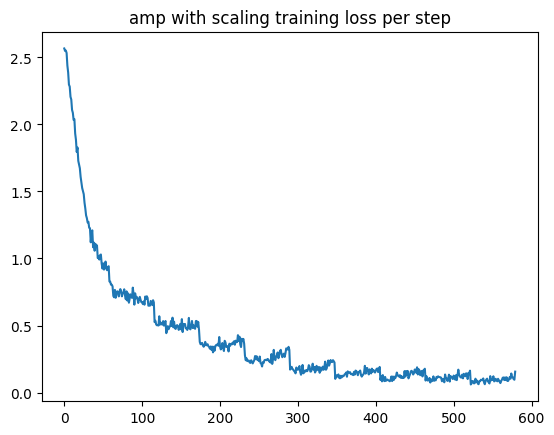

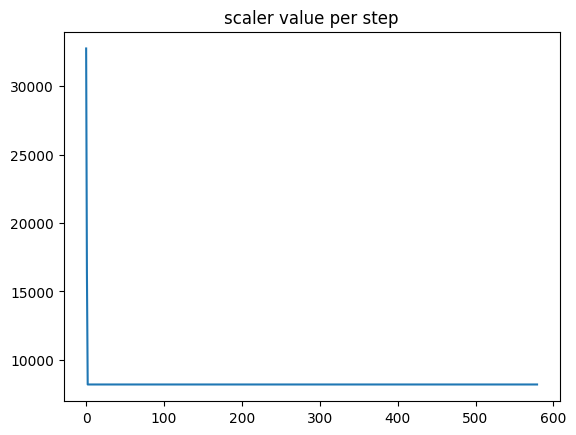

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(amp_withscaling_training_loss)
_ = plt.title("amp with scaling training loss per step")

plt.figure()
plt.plot(scale_list)
_ = plt.title("scaler value per step")

In [23]:
model = model.to(device)
model.eval()

total_target = []
total_pred = []
for batch_idx, (image, target) in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):

    with torch.no_grad():
      with torch.autocast(device_type="cuda"):
        output = model(image.to(device).half())
        prediction = torch.argmax(output, dim=-1)

    total_target.extend(target)
    total_pred.extend(prediction.detach().cpu().numpy())

print(classification_report(total_target, total_pred))

100%|██████████| 59/59 [00:11<00:00,  5.14it/s]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6000
           1       0.99      1.00      1.00      6000
           2       0.95      0.98      0.96      6000
           3       0.99      0.98      0.98      6000
           4       0.97      0.96      0.97      6000
           5       0.99      0.99      0.99      6000
           6       0.97      0.90      0.94      6000
           7       1.00      0.98      0.99      6000
           8       0.99      1.00      0.99      6000
           9       0.98      1.00      0.99      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000

